In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
       # print(os.path.join(dirname, filename))
        num = 0

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# getting all of the image paths and then sorting them in alphabetical order to make sure we have the right mask paired with 
# each image. After that we add the begining path that wasn't added. Then we look at the top 5 of each list to double check

import os
images_path = os.listdir('/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images')
masks_path = os.listdir('/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Masks')
images_path.sort()
masks_path.sort()
count = 0
for i in images_path:
    images_path[count] = os.path.join('/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images',i)
    count+=1
count = 0
for i in masks_path:
    masks_path[count] = os.path.join('/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Masks',i)
    count+=1
images_path[:5],masks_path[:5]



(['/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_1.jpg',
  '/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_10.jpg',
  '/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_100.jpg',
  '/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_1000.jpg',
  '/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_1002.jpg'],
 ['/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Masks/water_body_1.jpg',
  '/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Masks/water_body_10.jpg',
  '/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Masks/water_body_100.jpg',
  '/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Masks/water_body_1000.jpg',
  '/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Masks/water_body_1002.jpg'])

In [3]:
# here we load and resize each image. One thing is were check if the value is for the mask or not. If it is we will read
# the mask in grey scale, if it is the real image it will be in color. we make the values between 0-1 and then shape the image
# to 128x128
import cv2
import matplotlib.pyplot as plt
def load_resize(img,mask):
    newimg =  cv2.imread(img).astype(np.float32) / 255.
    newimg = cv2.resize(newimg, (128,128))
    if mask == 1:
        newimg =  cv2.imread(img, cv2.IMREAD_GRAYSCALE).astype(np.float32) /255.
        newimg = cv2.resize(newimg, (128,128))
    return newimg



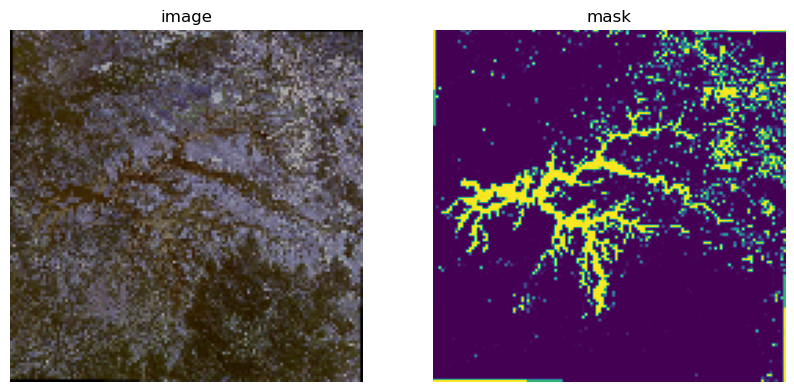

In [4]:
# plot origonal images and their mask side by side. it takes in a file path for both images and masks then uses the 
# load and resize function and then plots the two images side by side
def plot_images(images, masks):
    image = []
    
        
    img = load_resize(images,0)
    image.append(img)
    img = load_resize(masks,1)
    image.append(img)
    fig = plt.figure(figsize=(10, 7))
    fig.add_subplot(1, 2, 1)
  
    # showing image
    plt.imshow(image[0])
    plt.axis('off')
    plt.title("image")

    # Adds a subplot at the 2nd position
    fig.add_subplot(1, 2, 2)

    # showing image
    plt.imshow(image[1])
    plt.axis('off')
    plt.title("mask")
plot_images(images_path[0],masks_path[0])

In [5]:
# here we will be taking the list of masks and images run the load and resize then adds those values to a list. then taking 
# those lists and making them numpy arrays. after that we add a new axis to the masks that way we show it is grey scale
imageslist = []
maskslist = []
for image_path, mask_path in zip(images_path, masks_path):
    realimg = load_resize(image_path,0)
    maskimg = load_resize(mask_path,1)
    imageslist.append(realimg)
    maskslist.append(maskimg)
finalimages = np.array(imageslist)
finalmasks = np.array(maskslist)
finalmasks = finalmasks[:,:,:,np.newaxis]
print(finalimages.shape, finalmasks.shape)

(2841, 128, 128, 3) (2841, 128, 128, 1)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

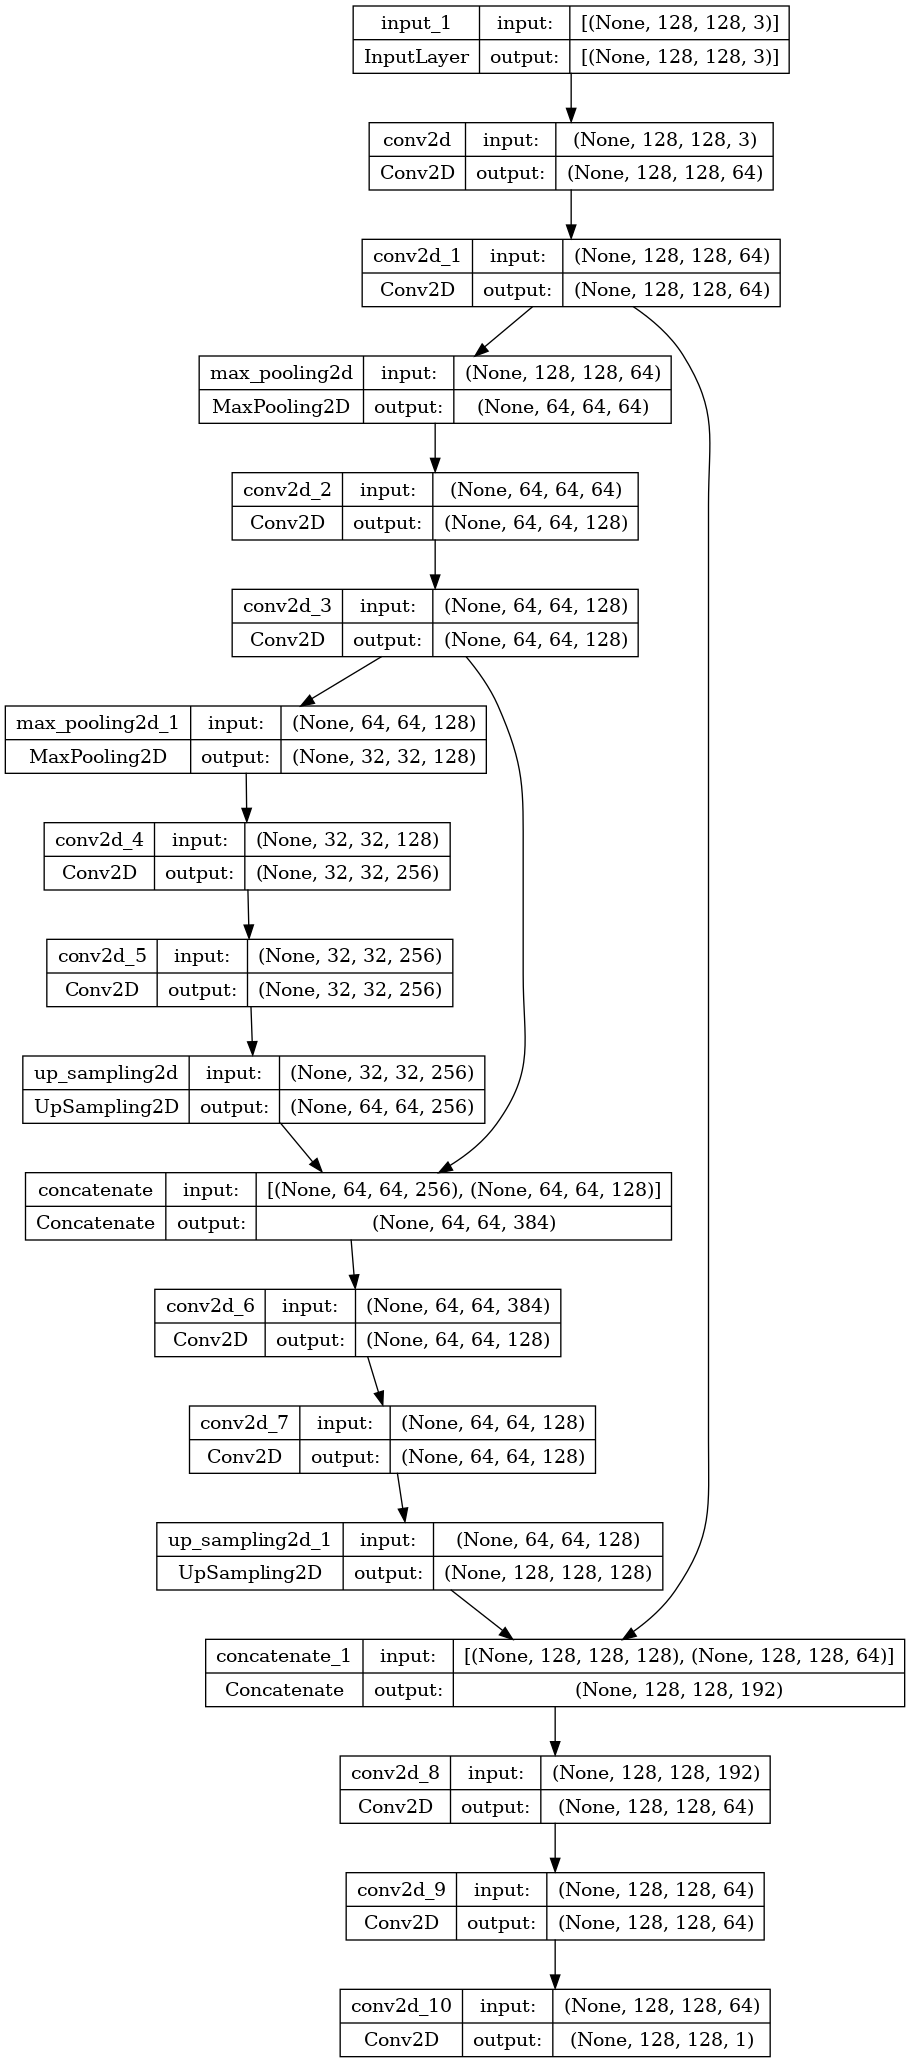

In [6]:
# here we create a model based on the unet encoder decoder model. it may not be perfect replication, but it should be pretty
# close
import tensorflow as tf
import keras
import keras.layers as layers

x = layers.Input((128, 128, 3))

enc1 =  layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
enc2 =  layers.Conv2D(64, (3, 3), padding='same', activation='relu')(enc1)
enc3 = tf.keras.layers.MaxPooling2D((2, 2))(enc2)
enc4 =  layers.Conv2D(128, (3, 3), padding='same', activation='relu')(enc3)
enc5 =  layers.Conv2D(128, (3, 3), padding='same', activation='relu')(enc4)
enc6 = tf.keras.layers.MaxPooling2D((2, 2))(enc5)
enc7 =  layers.Conv2D(256, (3, 3), padding='same', activation='relu')(enc6)
enc8 =  layers.Conv2D(256, (3, 3), padding='same', activation='relu')(enc7)

dec1 = tf.keras.layers.UpSampling2D((2, 2))(enc8)
dec2 = tf.keras.layers.Concatenate()([dec1, enc5])
dec3 =  layers.Conv2D(128, (3, 3), padding='same', activation='relu')(dec2)
dec4 =  layers.Conv2D(128, (3, 3), padding='same', activation='relu')(dec3)
dec5 = tf.keras.layers.UpSampling2D((2, 2))(dec4)
dec6 = tf.keras.layers.Concatenate()([dec5, enc2])
dec7 =  layers.Conv2D(64, (3, 3), padding='same', activation='relu')(dec6)
dec8 =  layers.Conv2D(64, (3, 3), padding='same', activation='relu')(dec7)
dec9 = layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(dec8)


model = tf.keras.Model(inputs=x, outputs=dec9)

tf.keras.utils.plot_model(model, show_shapes=True)

In [7]:
# splitting the data for train and validation set
from sklearn.model_selection import train_test_split
xtrain , xtest, ytrain, ytest = train_test_split(finalimages,finalmasks,test_size=0.3, random_state=42)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# early_stopping_cb = EarlyStopping(patience=5,restore_best_weights=True)
model_checkpoint_cb = ModelCheckpoint("/kaggle/working/waterbodiesmodel.h5",save_best_only=True)

model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
history = model.fit(xtrain,ytrain, batch_size=16, epochs=30,validation_data=(xtest, ytest))

Epoch 1/30
125/125 [==============================] - 42s 190ms/step - loss: 0.5456 - accuracy: 0.5987 - val_loss: 0.4788 - val_accuracy: 0.6281
Epoch 2/30
125/125 [==============================] - 17s 138ms/step - loss: 0.4897 - accuracy: 0.6301 - val_loss: 0.4494 - val_accuracy: 0.6506
Epoch 3/30
125/125 [==============================] - 17s 138ms/step - loss: 0.4444 - accuracy: 0.6534 - val_loss: 0.3937 - val_accuracy: 0.6829
Epoch 4/30
125/125 [==============================] - 18s 143ms/step - loss: 0.4133 - accuracy: 0.6732 - val_loss: 0.3595 - val_accuracy: 0.6972
Epoch 5/30
125/125 [==============================] - 17s 140ms/step - loss: 0.3857 - accuracy: 0.6843 - val_loss: 0.3716 - val_accuracy: 0.6913
Epoch 6/30
125/125 [==============================] - 18s 145ms/step - loss: 0.3641 - accuracy: 0.6933 - val_loss: 0.3613 - val_accuracy: 0.6948
Epoch 7/30
125/125 [==============================] - 18s 146ms/step - loss: 0.3555 - accuracy: 0.6969 - val_loss: 0.3655 - val_ac

1/1 [==============================] - 0s 22ms/step


Text(0.5, 1.0, 'real mask')

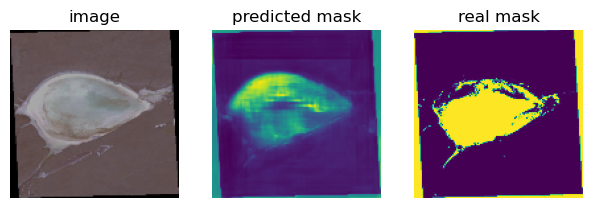

In [24]:
valimg = load_resize('/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_1000.jpg',0)
maskimg = load_resize('/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Masks/water_body_1000.jpg',1)

valimg1 = np.array(valimg)
valimg =np.expand_dims(valimg1, axis=0)
pred = model.predict(valimg)
fig = plt.figure(figsize=(10, 7))

plt.subplot(1, 4, 1)
# showing image
plt.imshow(valimg1)
plt.axis('off')
plt.title("image")

# Adds a subplot at the 2nd position
plt.subplot(1, 4, 2)

# showing image
plt.imshow(np.squeeze(pred))
plt.axis('off')
plt.title("predicted mask")

plt.subplot(1, 4, 3)

# showing image
plt.imshow(maskimg)
plt.axis('off')
plt.title("real mask")

In [ ]:

#  can see from above that the predicted mask seems to be pretty close to the image. when looking at the real mask it 
# seems like the real mask which is part of the training data actually isn't the greatest it shows some gaps and 
# the predicted doesn't which seems to be more like the image. There is deffintly room for imporvemnet. I could in the future
# try a different arcatecture or try doning some sort of transfer learning. but for creating a model from scratch and working
# with the data provided it looks like it does a pretty good job at showing where water is in images.